In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
data = pd.read_csv('100000.csv')

In [3]:
data.head()

,Unnamed: 0,Label,Answer_no,Question_cleaned,Answer_cleaned,word_count_question,word_count_answer,char_count_question,char_count_answer
0,0,0,0,what is a corporation,a company is incorporated in a specific nation...,4,72,23,432
1,1,0,1,what is a corporation,today there is a growing community of more th...,4,30,23,195
2,2,0,2,what is a corporation,corporation definition an association of indi...,4,37,23,245
3,3,0,3,what is a corporation,examples of corporation in a sentence he wo...,4,28,23,187
4,4,0,4,what is a corporation,a government-owned corporation as a utility ...,4,34,23,239


In [4]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.head()

,Label,Answer_no,Question_cleaned,Answer_cleaned,word_count_question,word_count_answer,char_count_question,char_count_answer
0,0,0,what is a corporation,a company is incorporated in a specific nation...,4,72,23,432
1,0,1,what is a corporation,today there is a growing community of more th...,4,30,23,195
2,0,2,what is a corporation,corporation definition an association of indi...,4,37,23,245
3,0,3,what is a corporation,examples of corporation in a sentence he wo...,4,28,23,187
4,0,4,what is a corporation,a government-owned corporation as a utility ...,4,34,23,239


In [5]:
data.head(10)

,Label,Answer_no,Question_cleaned,Answer_cleaned,word_count_question,word_count_answer,char_count_question,char_count_answer
0,0,0,what is a corporation,a company is incorporated in a specific nation...,4,72,23,432
1,0,1,what is a corporation,today there is a growing community of more th...,4,30,23,195
2,0,2,what is a corporation,corporation definition an association of indi...,4,37,23,245
3,0,3,what is a corporation,examples of corporation in a sentence he wo...,4,28,23,187
4,0,4,what is a corporation,a government-owned corporation as a utility ...,4,34,23,239
5,1,5,what is a corporation,mcdonalds corporation is one of the most recog...,4,62,23,354
6,0,6,what is a corporation,corporations are owned by their stockholders ...,4,49,23,307
7,0,7,what is a corporation,an association is an organized group of people...,4,51,23,325
8,0,8,what is a corporation,b corp certification shines a light on the com...,4,13,23,83
9,0,9,what is a corporation,llcs offer greater flexibility when it comes t...,4,40,23,218


In [0]:
data = data.iloc[0:100000]

In [6]:
data.shape

(100000, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
Label                  100000 non-null int64
Answer_no              100000 non-null int64
Question_cleaned       100000 non-null object
Answer_cleaned         100000 non-null object
word_count_question    100000 non-null int64
word_count_answer      100000 non-null int64
char_count_question    100000 non-null int64
char_count_answer      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [8]:
train = data.iloc[0:80000]
train.shape

(80000, 8)

In [9]:
train.head()

,Label,Answer_no,Question_cleaned,Answer_cleaned,word_count_question,word_count_answer,char_count_question,char_count_answer
0,0,0,what is a corporation,a company is incorporated in a specific nation...,4,72,23,432
1,0,1,what is a corporation,today there is a growing community of more th...,4,30,23,195
2,0,2,what is a corporation,corporation definition an association of indi...,4,37,23,245
3,0,3,what is a corporation,examples of corporation in a sentence he wo...,4,28,23,187
4,0,4,what is a corporation,a government-owned corporation as a utility ...,4,34,23,239


In [10]:
train = train.drop(['word_count_question','word_count_answer','char_count_question','char_count_answer'], axis = 1)
train.head()

,Label,Answer_no,Question_cleaned,Answer_cleaned
0,0,0,what is a corporation,a company is incorporated in a specific nation...
1,0,1,what is a corporation,today there is a growing community of more th...
2,0,2,what is a corporation,corporation definition an association of indi...
3,0,3,what is a corporation,examples of corporation in a sentence he wo...
4,0,4,what is a corporation,a government-owned corporation as a utility ...


In [11]:
train = train.drop(['Answer_no'], axis = 1)
train.head()

,Label,Question_cleaned,Answer_cleaned
0,0,what is a corporation,a company is incorporated in a specific nation...
1,0,what is a corporation,today there is a growing community of more th...
2,0,what is a corporation,corporation definition an association of indi...
3,0,what is a corporation,examples of corporation in a sentence he wo...
4,0,what is a corporation,a government-owned corporation as a utility ...


In [0]:
train.to_csv('Train.csv', index = True)

In [13]:
test = data.iloc[80000:]
test.shape

(20000, 8)

In [14]:
test = test.drop(['word_count_question','word_count_answer','char_count_question','char_count_answer', 'Answer_no'], axis = 1)
test.head()

,Label,Question_cleaned,Answer_cleaned
80000,0,what is star food,best -star dry puppy foods the following is a...
80001,0,what is star food,hhsc gives food snap and cash tanf benefits ...
80002,0,what is star food,to boost the demand for cars and accordingly ...
80003,0,what is star food,just what the world ordered discover tasty wh...
80004,0,what is star food,star food summary in star food dade works in ...


In [0]:
train.to_csv('Test.csv', index = True)

In [16]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2019-07-01 18:28:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  77.2MB/s    in 22s     

2019-07-01 18:29:13 (70.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = '/model'

In [18]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [0]:
from tqdm import tqdm

In [21]:
# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['Question_cleaned', 'Answer_cleaned']

# Iterate over the questions only of both training and test datasets
for dataset in tqdm([train, test]):
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
100%|██████████| 2/2 [00:30<00:00, 18.55s/it]


In [0]:
max_seq_length = 700
# Split to train validation
validation_size = 8000
training_size = len(train) - validation_size

X = train[questions_cols]
Y = train['Label']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size= validation_size)

# Split to dicts
X_train = {'left': X_train.Question_cleaned, 'right': X_train.Answer_cleaned}
X_validation = {'left': X_validation.Question_cleaned, 'right': X_validation.Answer_cleaned}
X_test = {'left': test.Question_cleaned, 'right': test.Answer_cleaned}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [26]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# mc = ModelCheckpoint('best_model.h1', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# Model variables
n_hidden = 100
gradient_clipping_norm = 1.25
batch_size = 128
n_epoch = 10

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', auroc])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs = n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

W0701 18:32:27.823030 140261268404096 deprecation.py:323] From <ipython-input-26-fba7885580be>:12: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0701 18:32:28.059886 140261268404096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/m

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 1211s 17ms/step - loss: 0.0990 - acc: 0.8999 - auroc: 0.5119 - val_loss: 0.0984 - val_acc: 0.9001 - val_auroc: 0.5185
Epoch 2/10
72000/72000 [==============================] - 1211s 17ms/step - loss: 0.0984 - acc: 0.8999 - auroc: 0.5129 - val_loss: 0.0976 - val_acc: 0.9001 - val_auroc: 0.5156
Epoch 3/10
72000/72000 [==============================] - 1209s 17ms/step - loss: 0.0971 - acc: 0.8998 - auroc: 0.5149 - val_loss: 0.0957 - val_acc: 0.9001 - val_auroc: 0.5145
Epoch 4/10
72000/72000 [==============================] - 1210s 17ms/step - loss: 0.0948 - acc: 0.8995 - auroc: 0.5190 - val_loss: 0.0941 - val_acc: 0.9000 - val_auroc: 0.5160
Epoch 5/10
72000/72000 [==============================] - 1196s 17ms/step - loss: 0.0934 - acc: 0.8995 - auroc: 0.5309 - val_loss: 0.0935 - val_acc: 0.9000 - val_auroc: 0.5229
Epoch 6/10
72000/72000 [==============================] - 1203s 17ms/st

In [0]:
import warnings

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 15]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

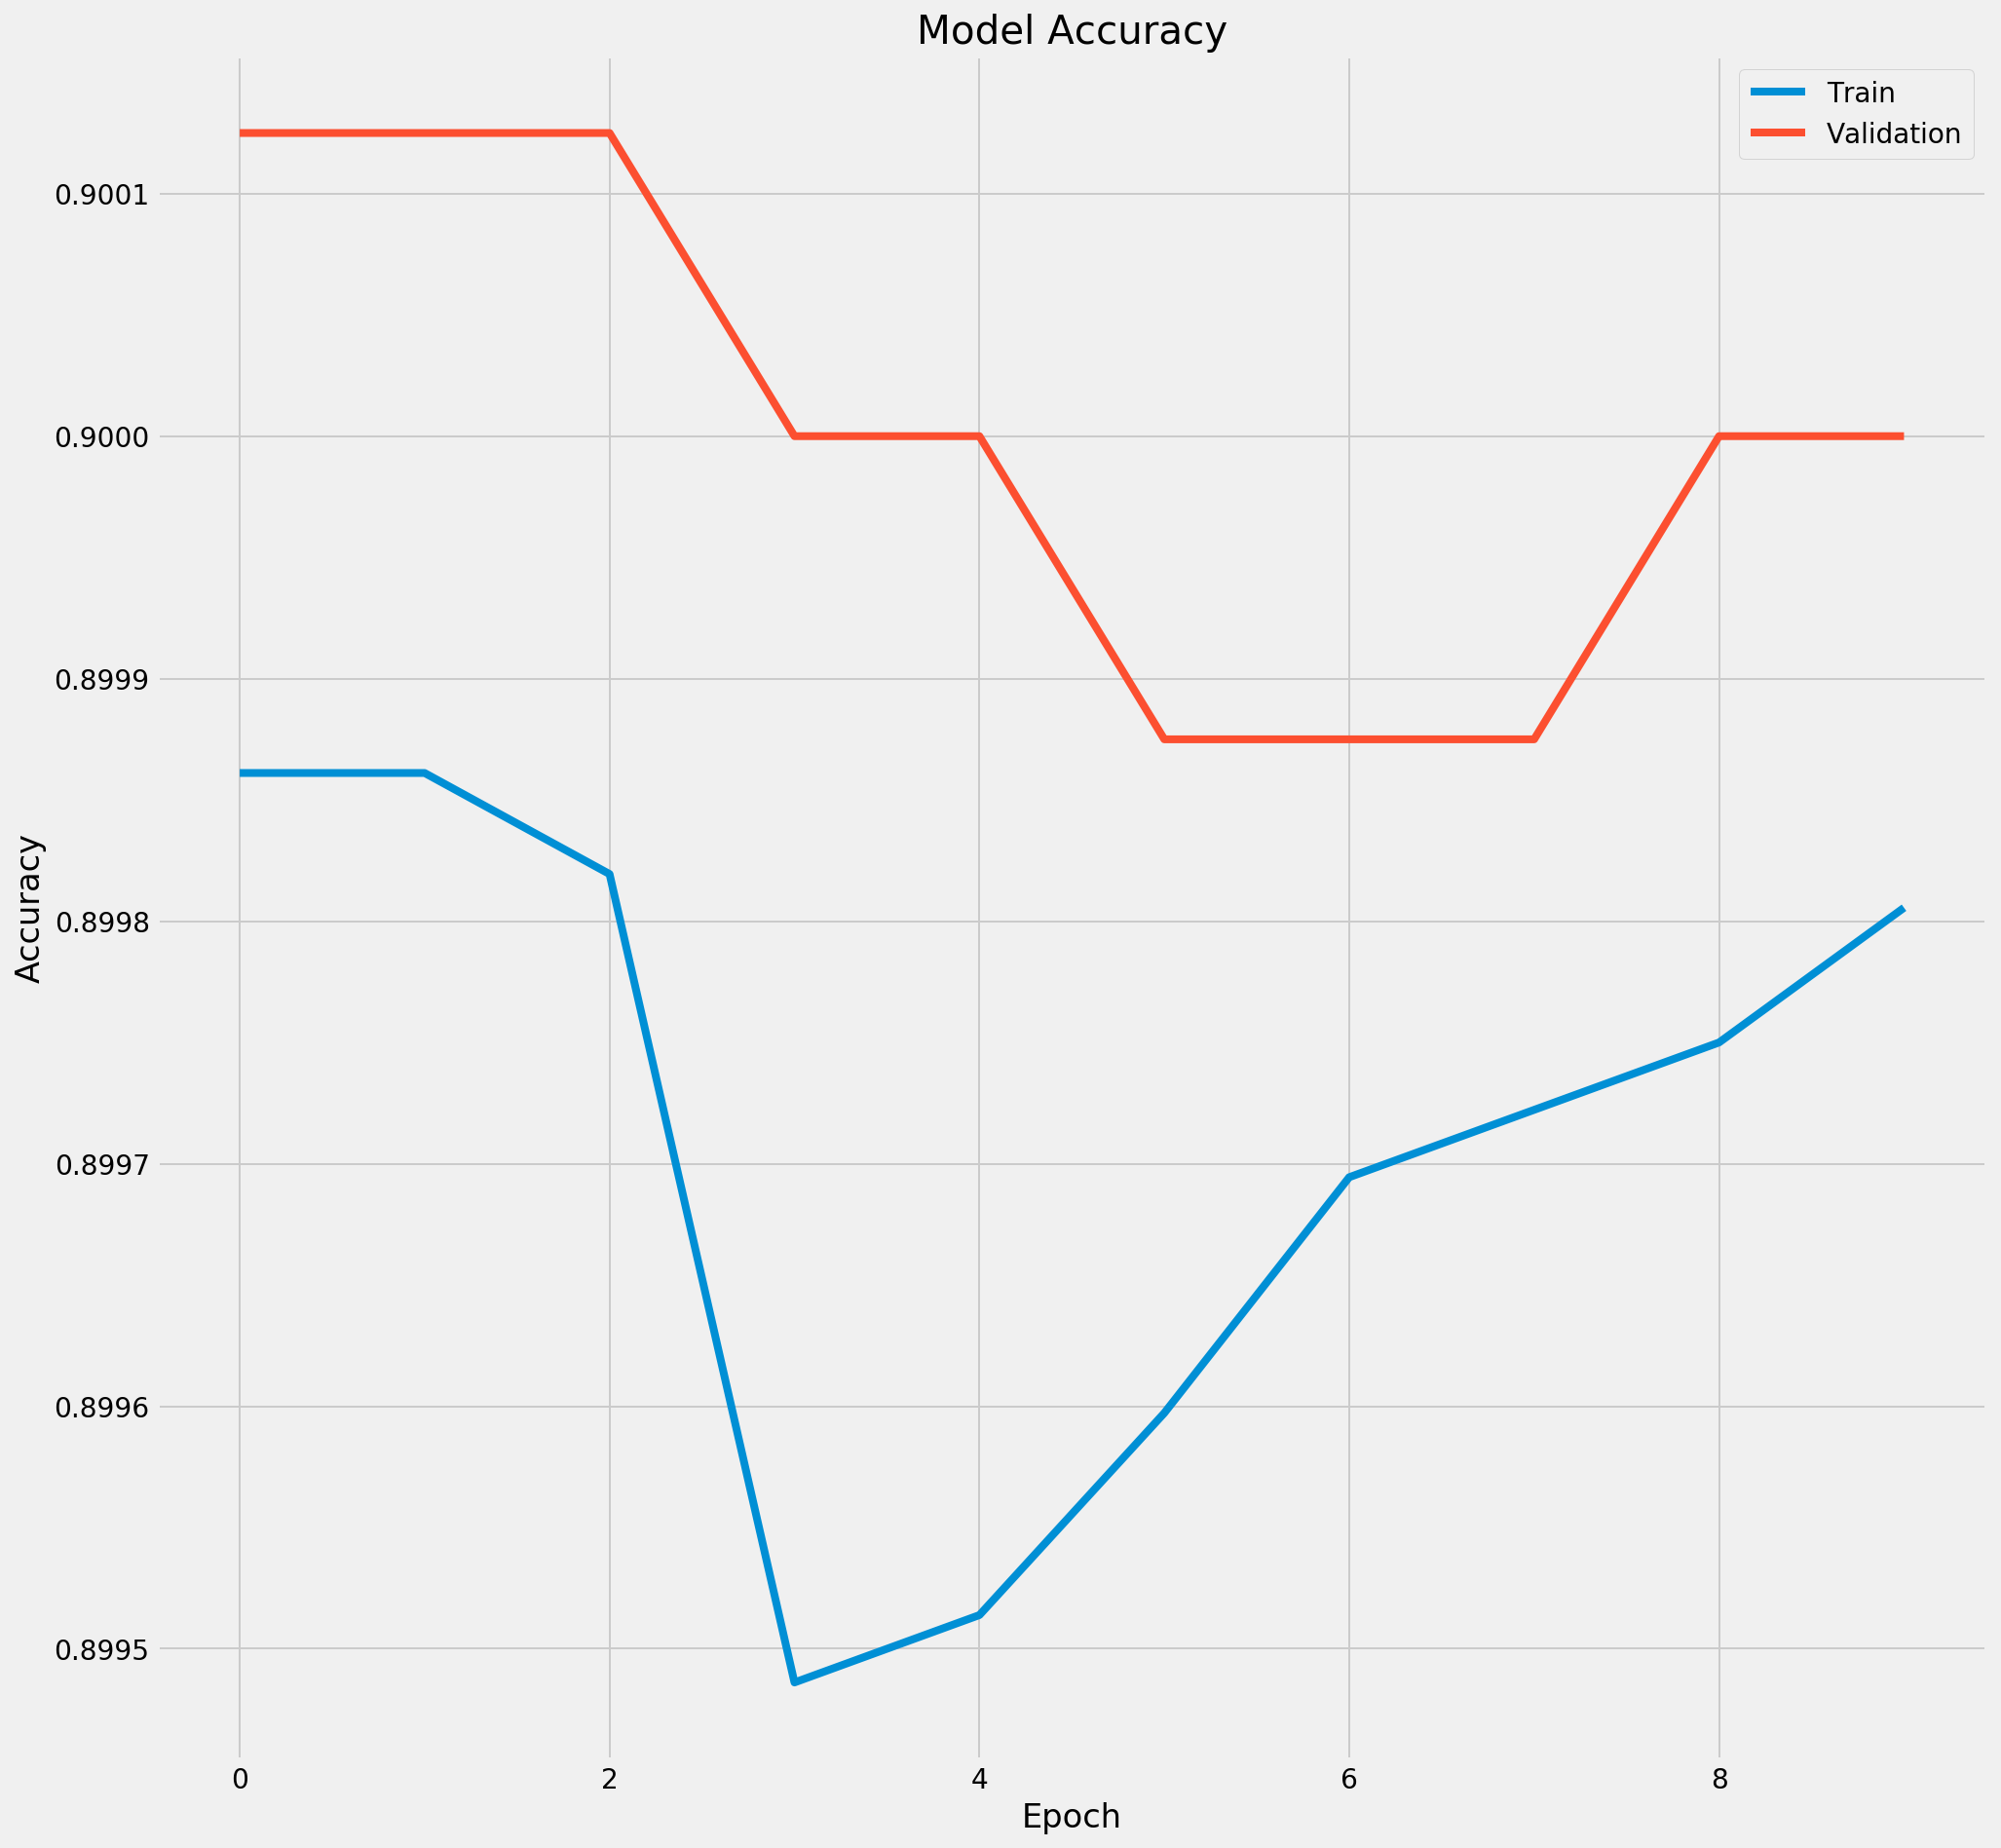

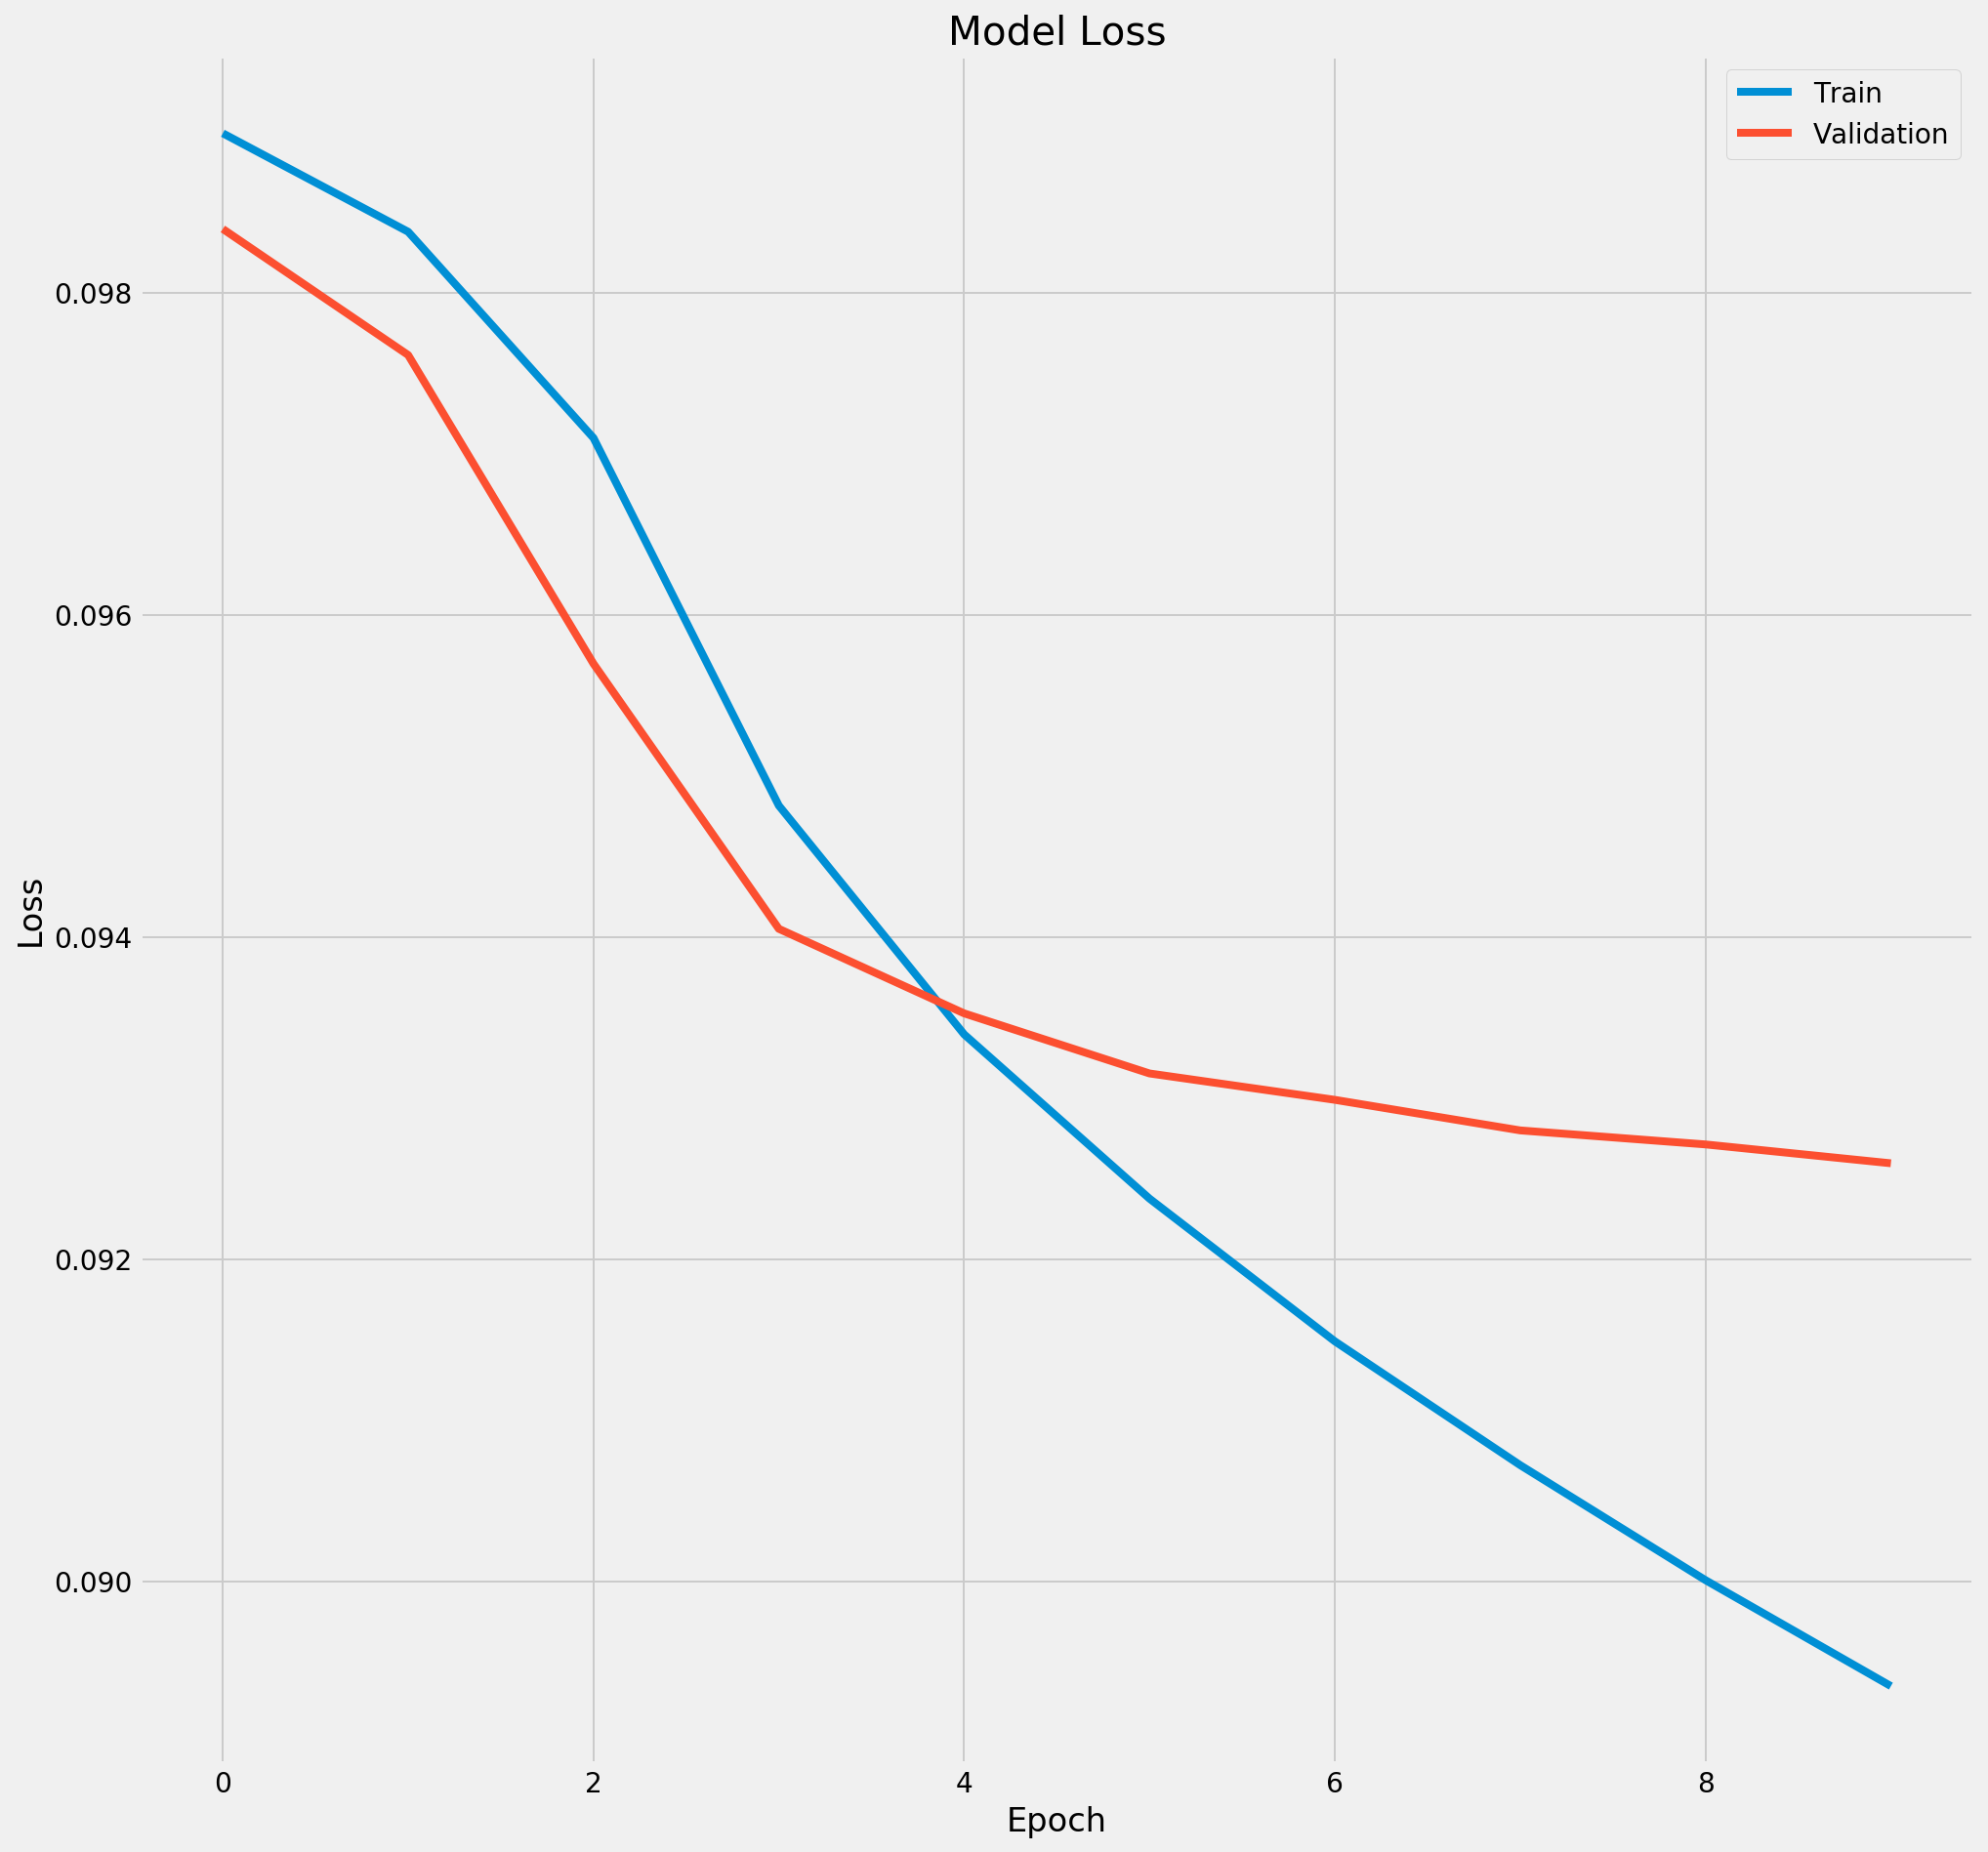

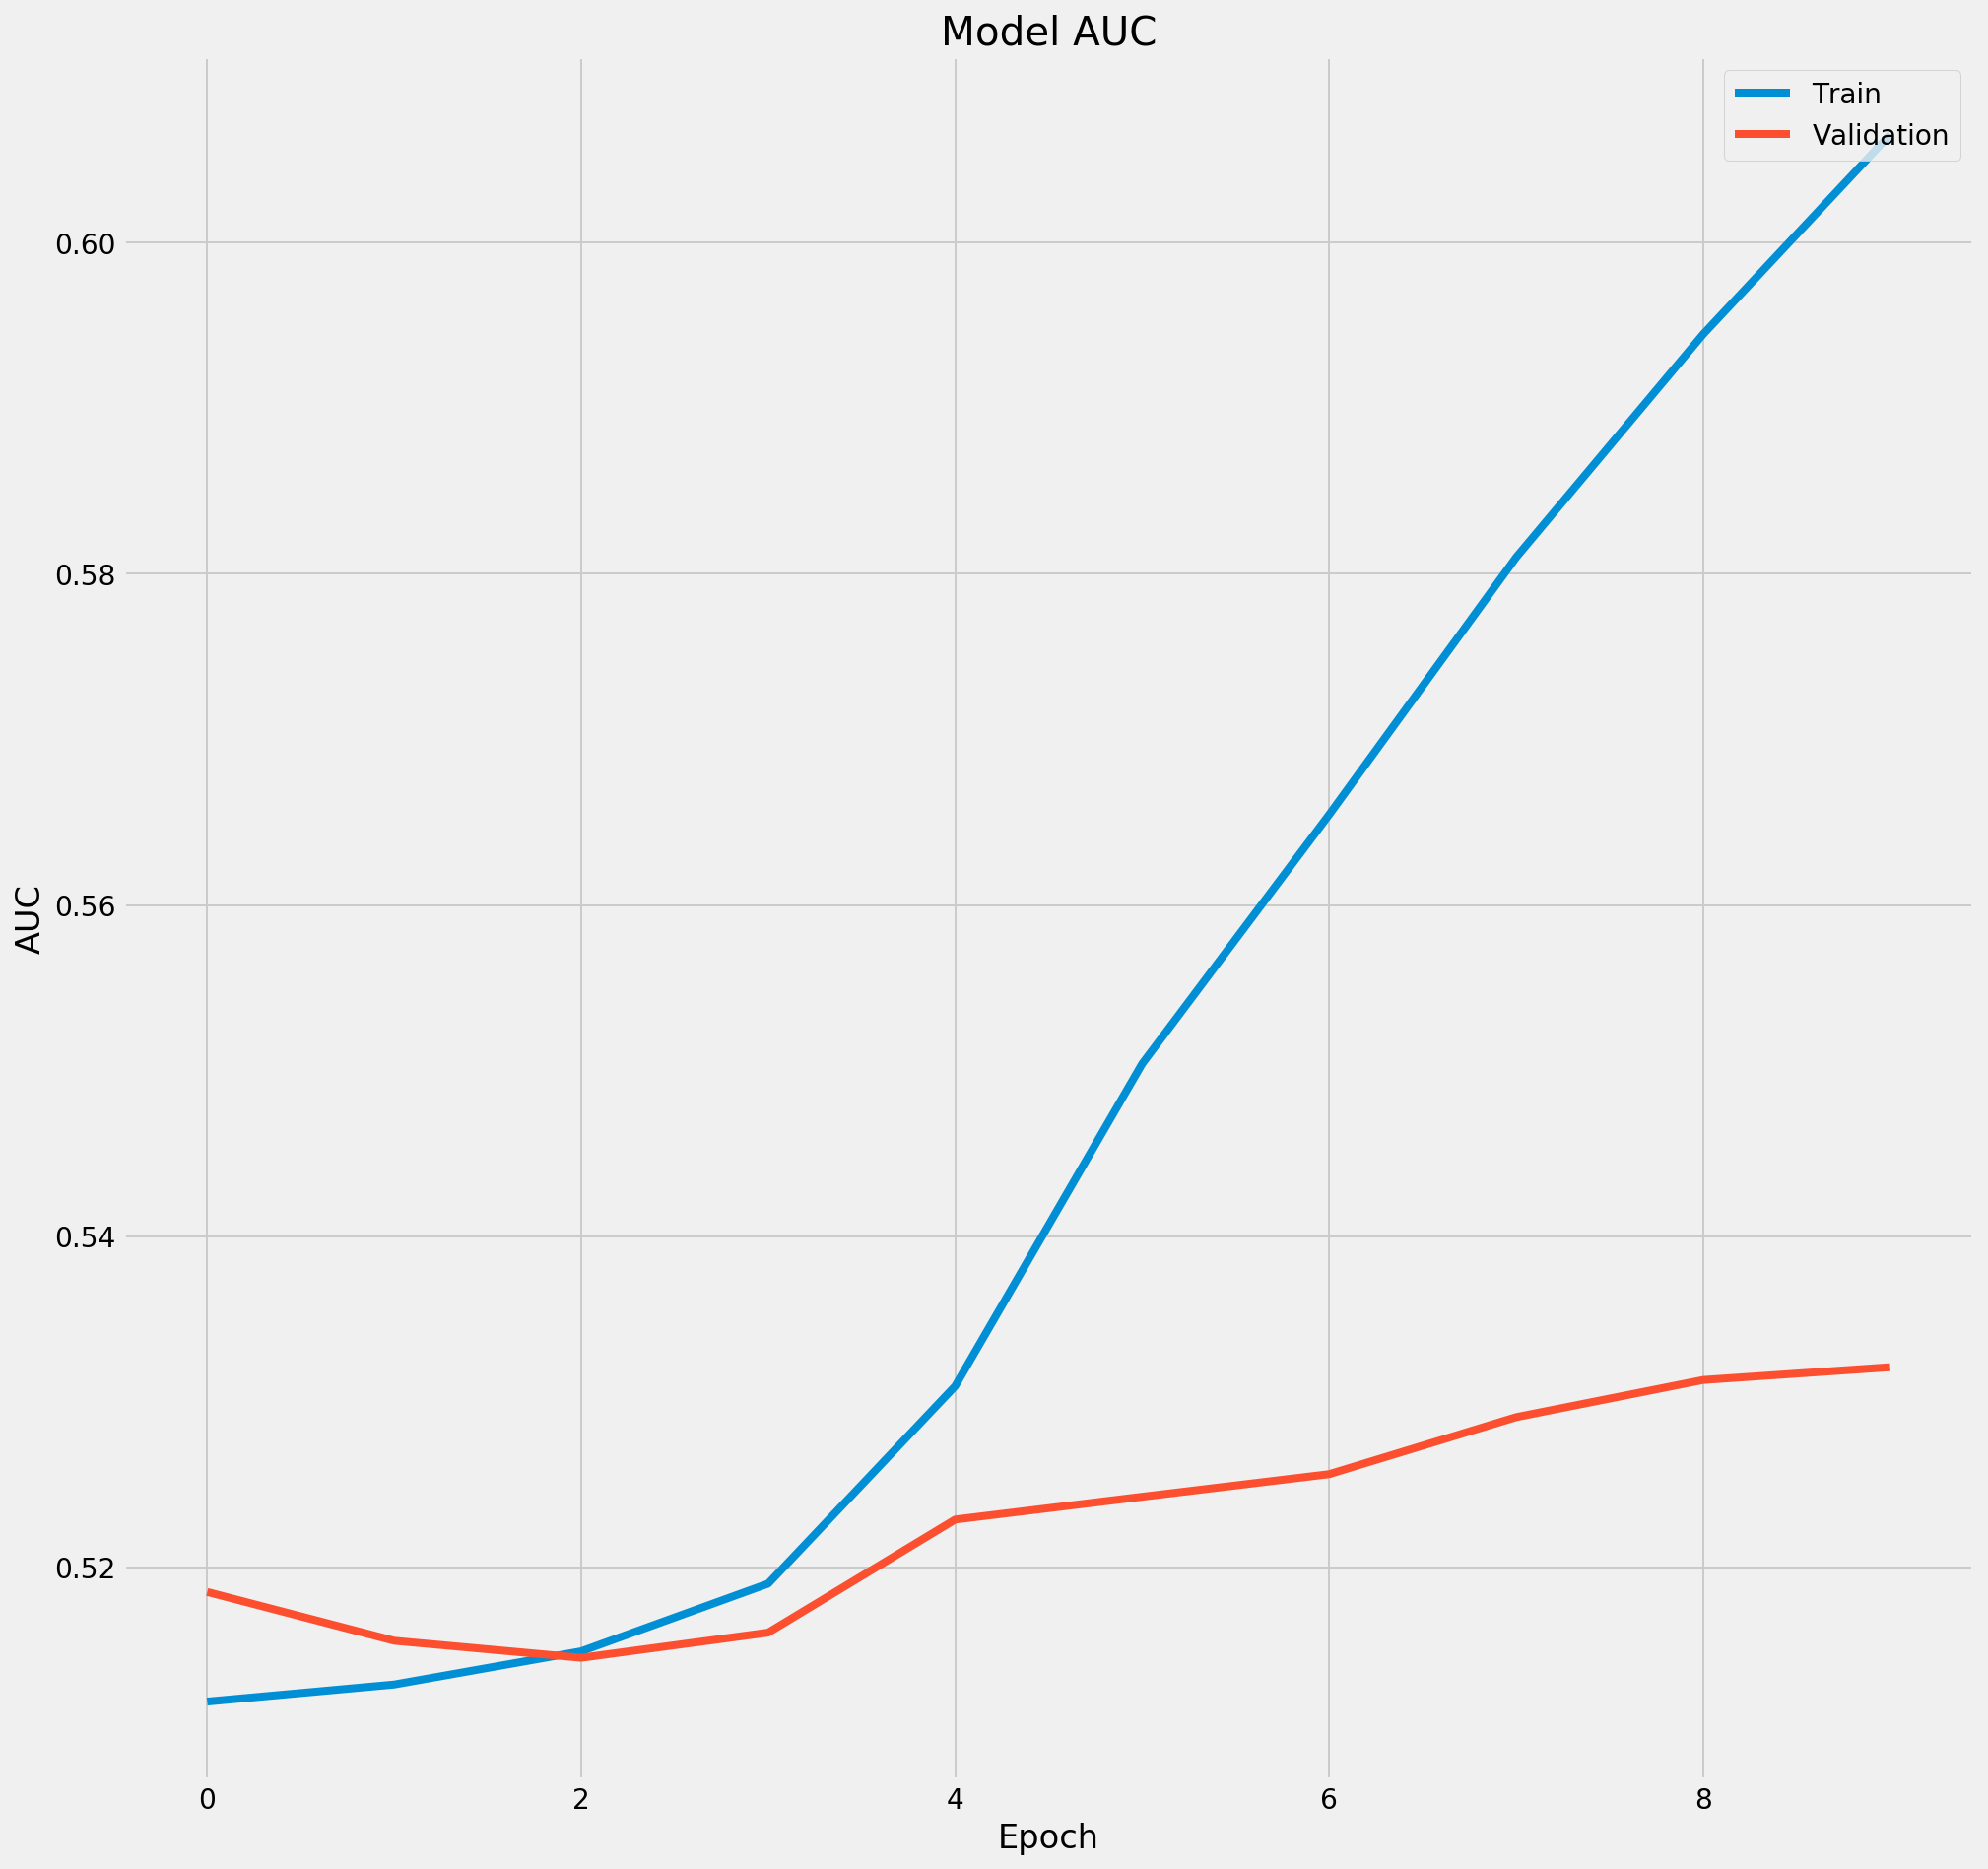

In [47]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print('\n')
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print('\n')
# Plot aucroc
plt.plot(malstm_trained.history['auroc'])
plt.plot(malstm_trained.history['val_auroc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()